# Test Code for Network ODE Simulation

We begin by setting up the network and assigning nodes in initial compartments that is, S is approximately N and I >> 0

In [62]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.integrate import odeint


# define parameters
n = 50 # number of nodes
p = 0.2 # edge probability
r = 5 # number of nodes in R compartment

# create the graph
G = nx.erdos_renyi_graph(n, p)

# add the 'compartment' attribute to all nodes
for node in G.nodes():
    G.nodes[node]['compartment'] = 'S'

# randomly select r nodes to assign to the R compartment
r_nodes = random.sample(G.nodes(), r)
for node in r_nodes:
    G.nodes[node]['compartment'] = 'I'

# print the compartments for all nodes
#for node in G.nodes():
#    print(f"Node {node} is in compartment {G.nodes[node]['compartment']}")


C:\Users\claire\AppData\Local\Temp\ipykernel_5616\1185903838.py:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  r_nodes = random.sample(G.nodes(), r)


We then get the degree distribution of the network

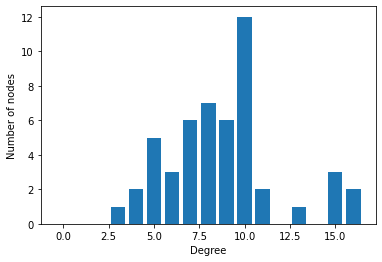

10

In [63]:
# get the degree distribution 
#returns list of degree frequencies; i.e. hist[i] = c, there are c nodes with degree i
hist = nx.degree_histogram(G)

# plot the degree distribution
plt.bar(range(len(hist)), hist)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.show()


G.degree(5)

Some test runs to understand the code setup. Note that lists use 0-base indexing in python.

In [64]:
# TO TRACK
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # sorted degree sequence
dhist = [degree_sequence.count(i) for i in range(max(degree_sequence) + 1)]  # degree histogram also equal to hist

print("degree sequence:", degree_sequence)
print("degree distribution:", dhist)


print(hist)
# prints: [0, 0, 0, 1, 4, 3, 4, 4, 9, 5, 6, 8, 4, 0, 0, 1, 1]
# all degree k: 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16 

print(hist[3]) # nodes with degree 3 --> hist[k] = no. of nodes with degree k

degree sequence: [16, 16, 15, 15, 15, 13, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 3]
degree distribution: [0, 0, 0, 1, 2, 5, 3, 6, 7, 6, 12, 2, 0, 1, 0, 3, 2]
[0, 0, 0, 1, 2, 5, 3, 6, 7, 6, 12, 2, 0, 1, 0, 3, 2]
1


To find all nodes in each compartment:

In [66]:
def CompartmentNodes(G):
    # get dictionary of nodes i that are in each compartment: {i: {'compartment' = 'S'}}
    Susceptibles = {i: G.nodes[i] for i in G.nodes if G.nodes[i]['compartment'] == 'S'}
    Exposed = {i: G.nodes[i] for i in G.nodes if G.nodes[i]['compartment'] == 'E'}
    Infecteds = {i: G.nodes[i] for i in G.nodes if G.nodes[i]['compartment'] == 'I'}
    Removed = {i: G.nodes[i] for i in G.nodes if G.nodes[i]['compartment'] == 'R'}
    
    # returns list of dicts [{Susceptibles}, {Exposed}, {Infecteds}, {Removed}]
    # i= 0,1,2,3 in CompartmentNodes(G)[i] returns S, E, I, or R, respectively
    return [Susceptibles, Exposed, Infecteds, Removed]

#CompartmentNodes(G)

[{1: {'compartment': 'S'},
  2: {'compartment': 'S'},
  3: {'compartment': 'S'},
  4: {'compartment': 'S'},
  5: {'compartment': 'S'},
  8: {'compartment': 'S'},
  10: {'compartment': 'S'},
  11: {'compartment': 'S'},
  12: {'compartment': 'S'},
  13: {'compartment': 'S'},
  14: {'compartment': 'S'},
  15: {'compartment': 'S'},
  16: {'compartment': 'S'},
  17: {'compartment': 'S'},
  18: {'compartment': 'S'},
  19: {'compartment': 'S'},
  20: {'compartment': 'S'},
  21: {'compartment': 'S'},
  22: {'compartment': 'S'},
  23: {'compartment': 'S'},
  24: {'compartment': 'S'},
  25: {'compartment': 'S'},
  26: {'compartment': 'S'},
  27: {'compartment': 'S'},
  28: {'compartment': 'S'},
  29: {'compartment': 'S'},
  30: {'compartment': 'S'},
  31: {'compartment': 'S'},
  33: {'compartment': 'S'},
  34: {'compartment': 'S'},
  35: {'compartment': 'S'},
  36: {'compartment': 'S'},
  37: {'compartment': 'S'},
  38: {'compartment': 'S'},
  39: {'compartment': 'S'},
  40: {'compartment': 'S'}

Now, we need to list all possible degrees k in the network (those of nonzero degrees).

In [67]:
# for each degree k and degree frequency in the distribution
# return indices of nonzero values in list, i.e. the nonzero degrees in the network
degrees = [k for k, dfreq in enumerate(hist) if dfreq != 0] 
print(degrees)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16]


From the degree distribution, for each degree k, we need to
1. Find all nodes with degree k
2. Find the nodes in each compartment with degree k, i.e. the nodes S_k, E_k, I_k, R_k

The first one is done by creating a function that will return the list of nodes that satisfy the given degree. This function creates two lists: 
1. a list of int values of the indices of the nodes that satisfy the given degree k
2. a list of dict values of the compartments of the nodes in 1

To be able to check and access these values, it is more convenient to store them in a dictionary that will contain both indices and nodes dicts. Because we will still be using the indices later, this function returns all three: (1) index list, (2) node list, and (3) dictionary of index and node list.

In [68]:
# nodes with degree k

# function to return nodes of degree k
# NOTE RETURNS INT TYPE NOT NODE DICT i.e. will not store node name only compartment
def nodesWithDegreeK(network, k):
    node_index = [index for index, degree in network.degree() if degree == k]
    nodelist = []
    
    for i in node_index:
        nodelist.append(G.nodes[i])
        
    # return list of nodes in index form (to iterate over graph properties)
    # and the list in dict form of their compartments
    return node_index, nodelist, dict(zip(node_index, nodelist))

# TEST
indices, nodesK, dictresults = nodesWithDegreeK(G, 10)
print("indices: ", indices)
#print("nodes: ", nodesK)
#print("dict: ", dictresults)
hist[8]

indices:  [0, 1, 5, 11, 13, 17, 18, 38, 39, 41, 48, 49]


7

We then create another function that will return the dictionary of nodes in each compartment that satisfy some degree k.

In [69]:
def CompartmentNodesDegreeK(network, k):
    indices, nodes_degree_k, nodesK = nodesWithDegreeK(network, k)    # recovers indices, nodes, and dict for nodes of degree k
    nodes_S_k, nodes_E_k, nodes_I_k, nodes_R_k = [], [], [], []       # list to contain nodes of degree k per compartment
    
    # create dict of nodes with degree k s.t. they are in S, E, I, or R
    
    nodes_S_k = {i: nodesK[i] for i in nodesK if nodesK[i]['compartment'] == 'S'}        
    #print("Susceptible nodes with degree ", k, ": ", nodes_S_k)
    
    nodes_E_k = {i: nodesK[i] for i in nodesK if nodesK[i]['compartment'] == 'E'}        
    #print("Exposed nodes with degree ", k, ": ", nodes_E_k)
    
    nodes_I_k = {i: nodesK[i] for i in nodesK if nodesK[i]['compartment'] == 'I'}        
    #print("Infected nodes with degree ", k, ": ", nodes_I_k)
    
    nodes_R_k = {i: nodesK[i] for i in nodesK if nodesK[i]['compartment'] == 'R'}        
    #print("Removed nodes with degree ", k, ": ", nodes_R_k)
    
    # returns a list of the dictionaries for easy access
    return [nodes_S_k, nodes_E_k, nodes_I_k, nodes_R_k]

We iterate this function over all values k in the degree distribution.

In [79]:
# for each degree k, 
for k in degrees:
    S, E, I, R = CompartmentNodesDegreeK(G, k)
    #print("S", S, "\nE", E, "\nI", I, "\nR", R)
    #print("Nodes of degree ", k, ":\n", CompartmentNodesDegreeK(G, k))

print(len(CompartmentNodesDegreeK(G, 10)[0])) # infecteds degree 10

11


To solve for the infection connectivity Phi, we first need to find all nodes with some degree k whose neighbors are infected and have some degree k'. That is, we need to find the infected neighbors of the nodes with degree k. To do this,
1. Access all nodes with degree k, let v_k
2. Get the degree distribution of the neighbors of v_k
3. For each degree k' in the degree distribution in (2), 
  - Find the frequency of each degree k'
  - Compute: k * P(k') * I_k
  - Sum up these products for all values k' in the distribution
4. Divide the sum in (3) by the average degree kmean (for consistency with builtin notations)

We note that the probability of a node having degree k and of having degree k' are independent of each other. That is, the probability of a node having degree k' given it is connected to one having degree k are independent, i.e. P(k'|k) = P(k'). Since k' and k are arbitrary, P(k') = P(k).

In [88]:
def Phi(network, degreesK, deg_hist):
    sum, kmean = 0, 0 # will hold sum for average degree
    
    for k in degreesK:
        I_k = len(CompartmentNodesDegreeK(network, k)[2])
        P_k = deg_hist[k]
        kmean = kmean + (k*P_k)
        
        sum = sum + (k*P_k*I_k)
        
        # To Track
        #print("\nDegree ", k, "\n")
        #print("I_k: ", I_k, "\nP_k: ", P_k, "\nAve degree: ", kmean, "\nSummation: ", sum )
    
    return sum/kmean

print(type(Phi(G, degrees, hist)))
Phi = Phi(G, degrees, hist)
print(Phi)

<class 'float'>
0.7191780821917808


In [80]:
k = 10

ODEparam = dict()
ODEparam['lambda'] = 0.1
ODEparam['epsilon'] = 0.04
ODEparam['gamma'] = 0.1
ODEparam['Phi'] = Phi

# initial conditions from network at t=0
S_k = len(CompartmentNodesDegreeK(G, k)[0])
E_k = len(CompartmentNodesDegreeK(G, k)[1])
I_k = len(CompartmentNodesDegreeK(G, k)[2])
R_k = len(CompartmentNodesDegreeK(G, k)[3])
    
initial_conditions = [S_k, E_k, I_k, R_k]

def networkODE(t, k, initial_conditions, ODEparam):
    # initial conditions from network at t=0
#    S_k = len(CompartmentNodesDegreeK(G, k)[0])
#    E_k = len(CompartmentNodesDegreeK(G, k)[1])
#    I_k = len(CompartmentNodesDegreeK(G, k)[2])
#    R_k = len(CompartmentNodesDegreeK(G, k)[3])
    
#    initial_conditions = [S_k, E_k, I_k, R_k]
    
    _lambda = ODEparam['lambda']
    epsilon = ODEparam['epsilon']
    gamma = ODEparam['gamma']
    Phi = ODEparam['Phi']
    
    def ODE(initial_conditions, t, k):
        
        deltaS_k = -_lambda*k*S_k*Phi
        deltaE_k = (_lambda*k*S_k*Phi) - (epsilon*E_k)
        deltaI_k = (epsilon*E_k)-(gamma*I_k)
        deltaR_k = gamma*I_k
        
        return [deltaS_k, deltaE_k, deltaI_k, deltaR_k]
    
    # find numerical solution to ode
    #soln = odeint(ODE, initial_conditions, t)
    
    #return soln
    return odeint(ODE, initial_conditions, t, args = (k,))


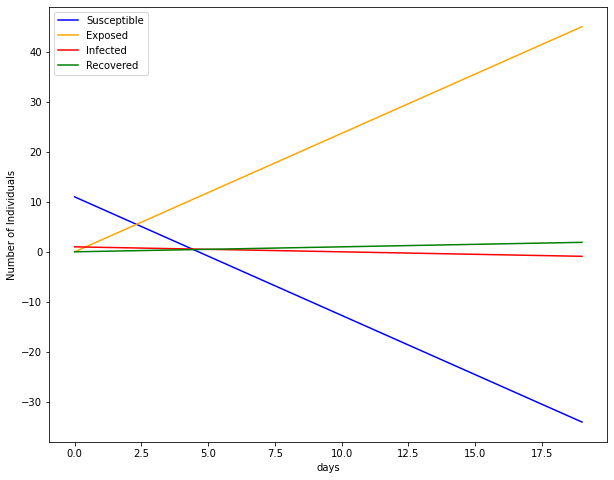

In [109]:
# TEST SINGLE PARAMETER SET

t = np.arange(20)
soln = networkODE(t, 3, initial_conditions, ODEparam)

S = soln[:, 0]
E = soln[:, 1]
I = soln[:, 2]
R = soln[:, 3]

#print(S, E, I, R)       # to check
    
fig, ax = plt.subplots(figsize=(10, 8))
labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered']
colors= ['blue', 'orange', 'red', 'green']
for i in range(4):
    ax.plot(t, soln[:, i], label=labels[i], color=colors[i])
ax.set_xlabel('days')
ax.set_ylabel('Number of Individuals')
ax.legend();

### Interactive Plots

In [13]:
from ipywidgets import interact, FloatSlider, IntSlider
import ipywidgets as widgets
from IPython.display import display
widgets.VBox([widgets.Label('Hello World!'), 
              widgets.IntSlider(min=-10, max=30, step=1, value=0), 
              widgets.Checkbox(description='Check me out')])

In [59]:
def plot_interactive(tsteps, Lambda, epsilon, gamma):
    t = np.arange(tsteps)
    
    ODEparam = dict()
    ODEparam['lambda'] = Lambda
    ODEparam['epsilon'] = epsilon
    ODEparam['gamma'] = gamma
    ODEparam['Phi'] = 0.7387755102040816
    
    S_k = len(CompartmentNodesDegreeK(G, k)[0])
    E_k = len(CompartmentNodesDegreeK(G, k)[1])
    I_k = len(CompartmentNodesDegreeK(G, k)[2])
    R_k = len(CompartmentNodesDegreeK(G, k)[3])
    initial_conditions = [S_k, E_k, I_k, R_k]
    
    soln = networkODE(t, k, initial_conditions, ODEparam)

    S = soln[:, 0]
    E = soln[:, 1]
    I = soln[:, 2]
    R = soln[:, 3]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered']
    colors= ['blue', 'orange', 'red', 'green']
    for i in range(4):
        ax.plot(t, soln[:, i], label=labels[i], color=colors[i])
    ax.set_xlabel('days')
    ax.set_ylabel('Number of Individuals')
    ax.legend();

In [60]:
# slider for time
t_slider = IntSlider(value=365, min=0, max=1000, description='timesteps')

# sliders for initial conditions
#E_slider = IntSlider(value=E_init, min=0, max=1000000, step=1000, description='Exposed')
#I_slider = IntSlider(value=I_init, min=0, max=N_init, step=100, description='Infected')
#R_slider = IntSlider(value=R_init, min=0, max=N_init, step=100, description='Recovered')

# sliders for parameters
#Rt_slider = FloatSlider(value=Rt, min=0, max=10, step=.1, description='Rt')
# beta_slider = FloatSlider(value=beta_init, min=0, max=1, step=.02, description='beta')
lambda_slider = FloatSlider(value=ODEparam['lambda'], min=0, max=.5, step=.02, description='lambda')
epsilon_slider = FloatSlider(value=ODEparam['epsilon'] , min=0, max=1, step=.02, description='epsilon')
gamma_slider = FloatSlider(value=ODEparam['gamma'] , min=0, max=.5, step=.02, description='gamma')

interact(plot_interactive, tsteps=t_slider, Lambda=lambda_slider, epsilon=epsilon_slider, gamma=gamma_slider);

interactive(children=(IntSlider(value=365, description='timesteps', max=1000), FloatSlider(value=0.1, descript…

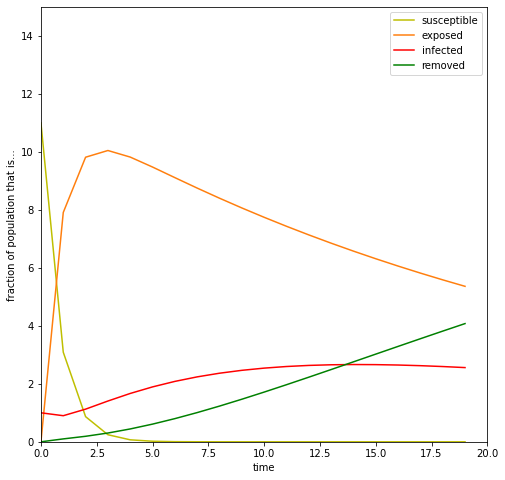

In [108]:
# TEST: ALTERNATE ODE SOLUTION 

def make_seir(Lambda, epsilon, gamma, Phi):
    #turn equations into update functions
    
    def deltaS(S, E, I, R):
        return -Lambda*k*S*Phi
    def deltaE(S, E, I, R):
        return ((Lambda*k*S*Phi) - (epsilon*E))
    def deltaI(S, E, I, R):
        return ((epsilon*E)-(gamma*I))
    def deltaR(S, E, I, R):
        return gamma*I
    
    return (deltaS, deltaE, deltaI, deltaR)

def epidemic_seir(T, k, Lambda, epsilon, gamma, Phi):
    (deltaS, deltaE, deltaI, deltaR) = make_seir(Lambda, epsilon, gamma, Phi)
    
    sss = [len(CompartmentNodesDegreeK(G, k)[0])]
    ess = [len(CompartmentNodesDegreeK(G, k)[1])]
    iss = [len(CompartmentNodesDegreeK(G, k)[2])]
    rss = [0]
    
    #print("\time = 0 : ", sss[-1], ess[-1], iss[-1], rss[-1])
    
    for t in range(1,T):
        #apply the change functions to the sub-populations of
        #the previous timestep to compute the changes
        dS = deltaS(sss[-1], ess[-1], iss[-1], rss[-1])
        dE = deltaE(sss[-1], ess[-1], iss[-1], rss[-1])
        dI = deltaI(sss[-1], ess[-1], iss[-1], rss[-1])
        dR = deltaR(sss[-1], ess[-1], iss[-1], rss[-1])

        #print("\ntime = ", t)
        #print("\narray: ", sss[-1], ess[-1], iss[-1], rss[-1])
        #print("\nds: ", dS, "\nde: ", dE, "\ndi: ", dI, "\ndr: ", dR)

        #the value at the next timestep are those at the
        #previous timestep plus the value of the change in that value
        sss.append(sss[-1] + dS)
        ess.append(ess[-1] + dE)
        iss.append(iss[-1] + dI)
        rss.append(rss[-1] + dR)

        #print("\n end array: ", sss, ess, iss, rss)
    
    return (list(range(0,20)), sss, ess, iss, rss)

T =20
N=50
Lambda = 0.1
epsilon = 0.04
gamma = 0.1
Phi = 0.7191780821917808
k = 10

(ts, sss, ess, iss, rss) = epidemic_seir(T, k, Lambda, epsilon, gamma, Phi)
#print("\n", ts, "\n", sss, "\n", ess, "\n", iss, "\n", rss)

fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# Plots
plt.plot(ts, sss, 'y', label='susceptible')
plt.plot(ts, ess, 'tab:orange', label='exposed')
plt.plot(ts, iss, 'r', label='infected')
plt.plot(ts, rss, 'g', label='removed')

# Set-Up

#plt.title(f'Progress over a BA network \n $(N = {N}, m = {param[BANetwork.M]} , \\lambda = {param[SEIR.P_INFECT_SYMPTOMATIC]}, \\epsilon = {param[SEIR.P_SYMPTOMS]}, \\gamma = {param[SEIR.P_REMOVE]})$')
    
plt.xlabel('time')
ax.set_xlim([0, T])
plt.ylabel('fraction of population that is...')
ax.set_ylim([0.0, 15])
plt.legend(loc = 'upper right')